In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
from rasterio import features
from affine import Affine
import matplotlib.pyplot as plt 
%matplotlib inline
import xarray as xr
# import rioxarray
import regionmask
import glob
from shapely.geometry import Polygon, MultiPolygon, shape
import src.clipping_functions as cf
# from src.clipping_functions import create_mask_from_geom, open_relative_humidity_file, extract_noon_array, nearest_latlong, shift_longitude_to_negative_coords

In [2]:
 
weather_crs = {'init': 'epsg:4326'} #needs to be hard coded in as it is
base_path_to_weather_data = "/data/raw_data/era5/unpacked/R/417331.R.2678.e5.oper.an.pl.128_157_r.ll025sc."  
nuts_regions_1m = gpd.read_file( '/data/raw_data/nuts_regions_highres//NUTS_RG_01M_2016_3857.geojson')
nuts_regions_changed_crs = nuts_regions_1m.to_crs(weather_crs)
#analysis done for wildfires in Var region of France
var_region = nuts_regions_changed_crs.query("NUTS_ID == 'FRL'")
shapes = [(shape, n) for n, shape in enumerate(var_region.geometry)]

nuts_regions_1m_crs = nuts_regions_1m.crs
bb = var_region.iloc[0].geometry.bounds
path_to_ground_truth_shp_files = '/data/raw_data/wildfires-ground-truth/france/vars/*.shp'
all_ground_truth_path_list = glob.glob(path_to_ground_truth_shp_files)


/home/ramani/.pyenv/versions/test-regionmask/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
combined_RH = []
combined_WF = []
wildfire_humidities_array = []
vars_nuts_code = 'FRL'
no_wildfire_humidities_array = []
nuts_regions_1m = cf.open_nuts_shp_with_consistent_crs(weather_crs)
for file in all_ground_truth_path_list:
    year = int(file[-14:-10])
    if year > 2002 : #although shapefiles available from 1953 the shapefiles are provided on a yearly instead of daily basis
        wildfire_ground_truth_changed_crs = cf.get_consistent_crs_shp_file(file, weather_crs)
        for index, row in wildfire_ground_truth_changed_crs.iterrows(): 
            date_of_wildfire_str = row.DATE_ECLOS.replace("-", "")
            
            open_RH_data = cf.open_RH_file_for_date(date_of_wildfire_str, base_path_to_weather_data)
            noon_RH_data = cf.get_noon_RH_data(open_RH_data)
            noon_RH_data = cf.change_longitude_to_neg(noon_RH_data)
            
            noon_RH_bound = cf.mask_RH_data_to_region(nuts_regions_1m, vars_nuts_code, weather_crs, noon_RH_data)
            nearest_min_coord, nearest_max_coord = cf.get_nearest_min_max_coords(row, noon_RH_bound)
            if nearest_min_coord == nearest_max_coord:
                nearest_coord = nearest_min_coord
                noon_RH_bound['WF_mask'] = cf.get_wf_mask(noon_RH_bound, nearest_coord)
                (noon_RH_bound, nearest_min_coord, neares)
                no_wildfire_xarray = noon_RH_bound.where(noon_RH_bound.WF_mask == 1, drop=True)
                wild_fire_xarray = noon_RH_bound.where(noon_RH_bound.WF_mask == 0, drop=True)   
                wildfire_humidities_array = np.hstack((wildfire_humidities_array, np.asarray(wild_fire_xarray.R.to_dict()['data']).flatten()))
                no_wildfire_humidities_array = np.hstack((no_wildfire_humidities_array, np.asarray(no_wildfire_xarray.R.to_dict()['data']).flatten()))
                combined_RH.append(noon_RH_bound.R[0][0])
                combined_WF.append(noon_RH_bound.WF_mask)

(array([0.        , 0.00784314, 0.04509804, 0.0372549 , 0.00588235,
        0.00196078, 0.00196078, 0.        , 0.        ]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 <a list of 9 Patch objects>)

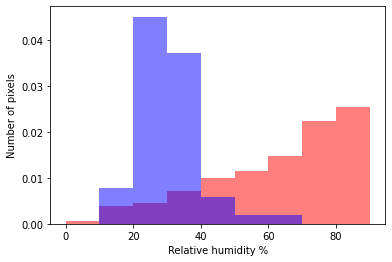

In [6]:
bins = [i for i in range(0,100,10)]
plt.xlabel('Relative humidity %')
plt.ylabel('Number of pixels')
plt.hist(no_wildfire_humidities_array, bins=bins, color='red', alpha=0.5, density=True)
plt.hist(wildfire_humidities_array, bins=bins, color='blue', alpha=0.5, density=True)

**References**

Check whether a point is inside a Polygon - https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python

In [ ]:
#         fig, ax = plt.subplots(figsize = (20,16)) 
#         plt.title("NUTS region FRL05 (Var) and ground truth of all wildfires in {}".format(year))
#         var_region.plot(ax=ax)
#         france_region.plot(ax=ax)
#         wildfire_groud_truth = gpd.read_file(file)
#         wildfire_ground_truth_changed_crs = wildfire_groud_truth.to_crs(weather_crs)
#         wildfire_ground_truth_changed_crs.plot(color='Red',edgecolor='k',linewidth = 2,ax=ax)
            

In [ ]:
# rasterise and mask xarray